# NYC 311 Calls Analysis 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df = pd.read_pickle('311_calls_all_12cols.pickle')

In [ ]:
# Checking for missing values and data types
print(df.isnull().sum())
print(df.dtypes)

# Converting 'Created Date' to datetime and setting it as index
df = df.set_index(pd.DatetimeIndex(df['Created Date']))
del df['Created Date']

         Unique Key
count  3.375241e+07
mean   3.800941e+07
std    1.208633e+07
min    1.056422e+07
25%    2.792274e+07
50%    3.796645e+07
75%    4.828555e+07
max    5.839048e+07


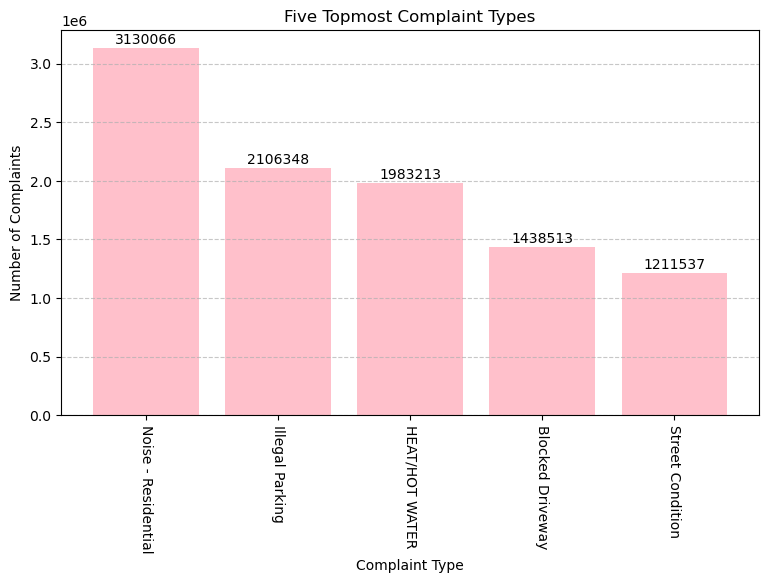

Earliest Date: 2010-01-01 00:00:00
Latest Date: 2023-07-31 23:59:29


In [17]:
# Descriptive statistics
print(df.describe())

# Count the number of each complaint type
complaint_counts = df['Complaint Type'].value_counts()

# Select the top 5 complaint types
top5_complaints = complaint_counts.head(5)

# Plot the top 5 complaint types
plt.figure(figsize=(9, 5))
#top5_complaints.plot(kind='bar')
bars = plt.bar(top5_complaints.index,top5_complaints.values, color="Pink")
plt.title('Five Topmost Complaint Types')
plt.xlabel('Complaint Type')
plt.ylabel('Number of Complaints')
plt.xticks(top5_complaints.index)
plt.xticks(rotation=270)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Annotate each bar with its count
for bar in bars:
    height = bar.get_height()
    plt.annotate(
        f"{int(height)}",  # Format the count as an integer
        xy=(bar.get_x() + bar.get_width() / 2, height),
        xytext=(0, 3),  # 3 points vertical offset for better placement
        textcoords="offset points",
        ha="center",
    )

plt.show()

# The range of the data
print("Earliest Date:", df.index.min())
print("Latest Date:", df.index.max())

In [4]:
# Filter data for the year 2022
data_2022 = df[df.index.year == 2022]

# Resample to get daily counts and calculate the average
average_daily_complaints_2022 = data_2022.resample('D')['Unique Key'].count().mean()
print("Average Number of Daily Complaints in 2022:", average_daily_complaints_2022)

Average Number of Daily Complaints in 2022: 8684.320547945206


In [5]:
# Group by date and count the number of calls
calls_per_day = df.groupby(df.index.date).size()

# Find the date with the maximum number of calls
max_calls_date = calls_per_day.idxmax()
max_calls_count = calls_per_day.max()

print(f"Date with Maximum Number of Calls: {max_calls_date}, Number of Calls: {max_calls_count}")

Date with Maximum Number of Calls: 2020-08-04, Number of Calls: 24415


In [6]:
# Filter data for the date with maximum calls
data_max_calls = df[df.index.date == max_calls_date]

# Find the most common complaint type
most_common_complaint = data_max_calls['Complaint Type'].value_counts().idxmax()
print(f"Most Common Complaint on {max_calls_date}: {most_common_complaint}")

Most Common Complaint on 2020-08-04: Damaged Tree


In [7]:
# Group by year and month, then count the number of calls
calls_per_month = df.groupby([df.index.year, df.index.month]).size()

# Find the month with the fewest calls
quietest_month_info = calls_per_month.idxmin()
quietest_month_count = calls_per_month.min()

print(f"Quietest Month (Year, Month): {quietest_month_info}, Number of Calls: {quietest_month_count}")

Quietest Month (Year, Month): (2012, 4), Number of Calls: 137661


In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Make sure the DataFrame is sorted by the DateTime index
df.sort_index(inplace=True)

# Resample data to daily frequency and fill missing values if there are any
daily_data = df['Unique Key'].resample('D').count()

# The index must have a frequency set (e.g., 'D' for daily frequency)
daily_data = daily_data.asfreq('D')

# Perform ETS decomposition
decomposition = seasonal_decompose(daily_data, model='additive')

# Extract and round the seasonal component for 2020-12-25
seasonal_component = round(decomposition.seasonal.loc['2020-12-25'])
print("Seasonal Component on 2020-12-25:", seasonal_component)

Seasonal Component on 2020-12-25: 183


In [14]:
# Calculate autocorrelation with lag of 1
from statsmodels.tsa.stattools import acf
print("Autocorrelation with Lag of 1:", acf(daily_data)[1])

Autocorrelation with Lag of 1: 0.7527117670106869


In [15]:
from prophet import Prophet
from sklearn.metrics import mean_squared_error

# Prepare the data for Prophet
prophet_data = daily_data.reset_index()
prophet_data.columns = ['ds', 'y']

# Split the data into training and test sets
train = prophet_data[:-90]
test = prophet_data[-90:]

# Initialize and fit the Prophet model
model = Prophet()
model.fit(train)

# Make predictions
predictions = model.predict(test[['ds']])

# Calculate RMSE
rmse = mean_squared_error(test['y'], predictions['yhat'], squared=False)
print("RMSE on Test Set:", rmse)

17:31:39 - cmdstanpy - INFO - Chain [1] start processing
17:31:40 - cmdstanpy - INFO - Chain [1] done processing


RMSE on Test Set: 860.2396367793558
